# Customer Segmentation: KMeans Algorithm

In this project, we will be trying to develop an end-to-end data science application. The aim of the project is to perform customer segmentation using Mall customers data with the following attributes:

* CustomerID - Unique ID assigned to customer.
* Gender - Gender of customer.
* Age - Age of Customer.
* Annual Income (k$)  - Annual income of cutomer.
* Spending Score (1-100) - Score Assigned to cutomer based on bahavior and spending nature.

We will be doing segmentation using **Spending Score** and **Annual Income**.

In [150]:
import os
os.environ["OMP_NUM_THREADS"]='1'

In [151]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [152]:
file = 'MallCustomers.csv'

In [153]:
df = pd.read_csv(file)

In [154]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [156]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [157]:
def spending_group(x):
    if  x <=33:
        return 'low'
    elif x > 33 and x <= 66:
        return 'moderate'
    else:
        return 'high'
    
def income_group(x):
    if  x <=52:
        return 'low income'
    elif x > 52 and x <= 156:
        return 'middle income'
    else:
        return 'upper income'
    
def age_group(x):
    if x >= 18 and x <=35:
        return 'young adult'
    elif x >= 36 and x <= 55:
        return 'middle aged'
    else:
        return 'old adult'

In [158]:
df['Age Group'] = df.Age.apply(age_group)
df['Income Group']=df['Annual Income (k$)'].apply(income_group)
df['Spending Group']=df['Spending Score (1-100)'].apply(spending_group)

In [159]:
df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age Group,Income Group,Spending Group
195,196,Female,35,120,79,young adult,middle income,high
196,197,Female,45,126,28,middle aged,middle income,low
197,198,Male,32,126,74,young adult,middle income,high
198,199,Male,32,137,18,young adult,middle income,low
199,200,Male,30,137,83,young adult,middle income,high


## Exploring gender

In [160]:
print(sns.color_palette().as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


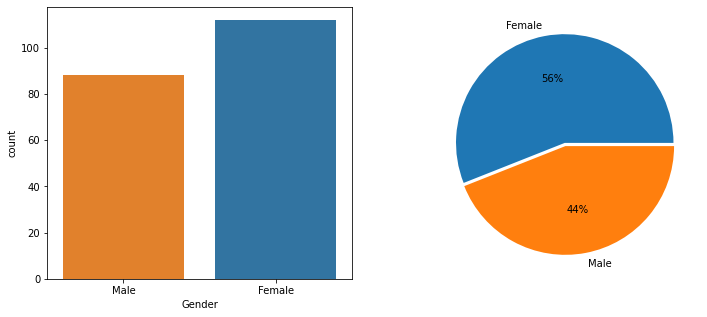

In [161]:
figure,axes = plt.subplots(1,2,figsize=(12, 5))
sns.countplot(data=df, x='Gender', ax=axes[0],palette=['#ff7f0e','#1f77b4'])
axes[1].pie(df.Gender.value_counts(),explode=[0,0.03],labels=['Female','Male'],autopct="%.0f%%");

We see that most customers are females.

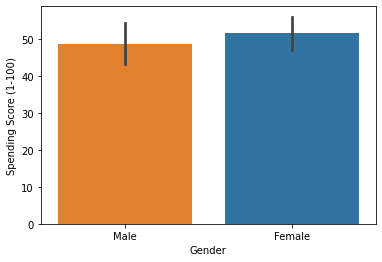

In [162]:
sns.barplot(data=df,x='Gender',y='Spending Score (1-100)',palette=['#ff7f0e','#1f77b4']);

In [163]:
pivot = df.pivot_table(index='Gender',values=['Spending Score (1-100)'],aggfunc='mean')
pivot

,Spending Score (1-100)
Gender,
Female,51.526786
Male,48.511364


We can see that females on average spend more than males.

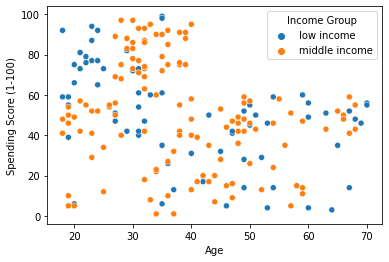

In [164]:
sns.scatterplot(data=df,x='Age',y='Spending Score (1-100)',hue='Income Group');

## Exploring Age

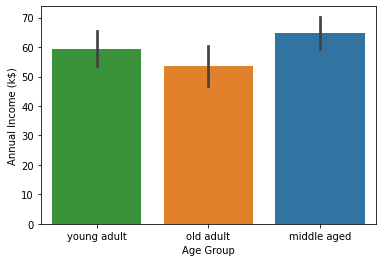

In [165]:
sns.barplot(data=df,x='Age Group',y='Annual Income (k$)',palette=['#2ca02c','#ff7f0e','#1f77b4']);

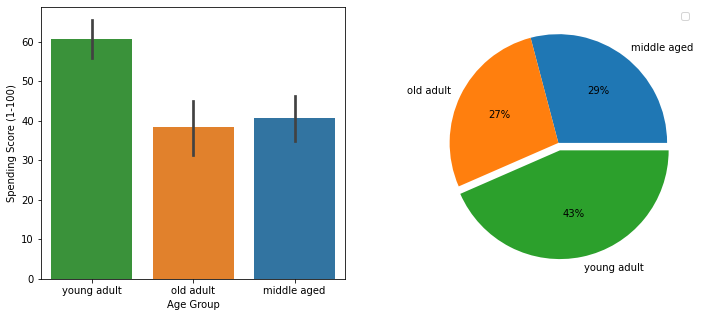

In [166]:
figure,axes = plt.subplots(1,2,figsize=(12, 5))
sns.barplot(data=df,x='Age Group',y='Spending Score (1-100)',ax=axes[0],palette=['#2ca02c','#ff7f0e','#1f77b4']);
pivot = df.pivot_table(index='Age Group',values=['Spending Score (1-100)'],aggfunc='mean')
pivot.plot(kind='pie',subplots=True,autopct="%.0f%%",ax=axes[1],explode=[0,0,0.07])
plt.ylabel('')
plt.legend([]);

Young Adults on averge spend more than any age group.

## Exploring Spending Score and Annual Income

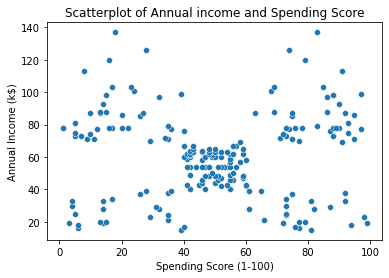

In [167]:
sns.scatterplot(data=df,x='Spending Score (1-100)',y='Annual Income (k$)')
plt.title("Scatterplot of Annual income and Spending Score");

We can see that there some grouped data points follow a pattern. The data form 'clusters'.

## Split

### Preprocessing

In [168]:
ss = StandardScaler()

In [169]:
X = df[['Annual Income (k$)','Spending Score (1-100)']]

We will be doing segmentation using **Spending Score** and **Annual Income**.

In [170]:
X_means = ss.fit_transform(X)

### Train Test Split

In [171]:
X_train,Xtest = train_test_split(X_means , test_size=0.2, shuffle=True, random_state=42)

### Elbow Plot

To find the correct number of clusters

In [172]:
inertia = []
for i in range(1,11):
    model = KMeans(n_clusters=i,n_init=i,init='k-means++',random_state=42)
    model.fit(X_train)
    inertia.append(model.inertia_)

In [173]:
clusters = [i for i in range(1,11)]

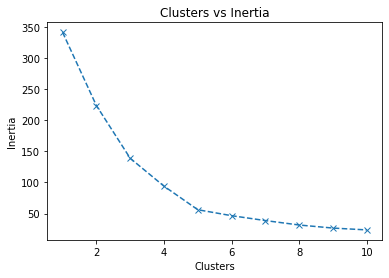

In [174]:
plt.plot(clusters, inertia, 'x--')
plt.title("Clusters vs Inertia")
plt.xlabel("Clusters")
plt.ylabel("Inertia");

In [175]:
silhouette_scores = []

for i in range(2,11):
    model = KMeans(n_clusters=i, n_init='auto', init='k-means++', random_state=42)
    model.fit(X_train)
    score = silhouette_score(X_train, model.labels_)
    silhouette_scores.append(score)

silhouette_scores

[0.40344930706913934,
 0.45404862424077985,
 0.47721891230990243,
 0.5509842461121202,
 0.5408225711237818,
 0.536669787130034,
 0.4509937596508946,
 0.4566345256771399,
 0.4335415087980149]

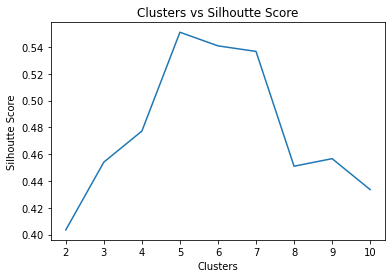

In [176]:
sns.lineplot(x=[i for i in range(2,11)], y=silhouette_scores)
plt.title("Clusters vs Silhoutte Score")
plt.xlabel("Clusters")
plt.ylabel("Silhoutte Score");

From the elbow plot and silhoutte score we can see that the optimum number of clusters is **5**

## Model

In [177]:
model = KMeans(n_clusters=5, n_init='auto', init='k-means++', random_state=42)
model.fit(X_means)
df['Labels'] = model.labels_

In [178]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age Group,Income Group,Spending Group,Labels
0,1,Male,19,15,39,young adult,low income,moderate,2
1,2,Male,21,15,81,young adult,low income,high,3
2,3,Female,20,16,6,young adult,low income,low,2
3,4,Female,23,16,77,young adult,low income,high,3
4,5,Female,31,17,40,young adult,low income,moderate,2


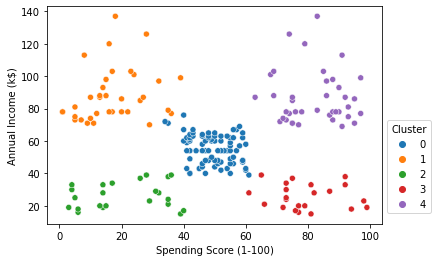

In [179]:
sns.scatterplot(data=df,
                x=df['Spending Score (1-100)'], 
                y=df['Annual Income (k$)'], 
                hue='Labels',
                palette=sns.color_palette()[:5]
               )
plt.legend(title='Cluster',bbox_to_anchor=(1,0.5));